# Bibliotecas

In [3]:
import pennylane as qml
from pennylane.templates.layers import RandomLayers

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import KernelPCA
from sklearn import preprocessing

# Teste de medição

In [4]:
# Configuração do dispositivo com 1 qubit e 100 shots
dev = qml.device("lightning.qubit", wires=1, shots=100)

# Definição do circuito
@qml.qnode(dev)
def hadamard_circuit():
    # Aplica a porta Hadamard no qubit 0
    #qml.Hadamard(wires=0)
    qml.PauliX(0)
    # Mede o qubit na base Z
    return qml.sample(qml.PauliY(0))

# Executa o circuito
results = hadamard_circuit()

# Exibe os resultados
print("Resultados das medições:", results)
print("Proporção de +1:", np.sum(results == 1) / len(results))
print("Proporção de -1:", np.sum(results == -1) / len(results))


Resultados das medições: [-1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.
  1. -1.  1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
  1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1.
 -1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.]
Proporção de +1: 0.48
Proporção de -1: 0.52


# Método convencional

## Inicio da implementação 

In [5]:
qubits = 8  # the number of qubits on which the unitaries act
n_shots = 100  # the number of times we can use each unitary
circuits=30

## Função para gerar circuitos

In [6]:
np.random.seed(234087)

layers, gates = 10, 10  # the number of layers and gates used in RandomLayers


def generate_circuit(shots):
    """
    generate a random circuit that returns a number of measuement samples
    given by shots
    """
    dev = qml.device("lightning.qubit", wires=qubits, shots=shots)

    @qml.qnode(dev)
    def circuit(ts=False):

        if ts == True:
            ops = [qml.RY]  # time-symmetric unitaries
        else:
            ops = [qml.RX, qml.RY, qml.RZ]  # general unitaries

        weights = np.random.rand(layers, gates) * np.pi
        RandomLayers(weights, wires=range(qubits), rotations=ops, seed=np.random.randint(0, 10000))

        return [qml.sample(op=qml.PauliY(q)) for q in range(qubits)]

    return circuit

## Teste

In [7]:
# the measurement outcomes for the first 3 shots
circuit = generate_circuit(n_shots)
print(np.array(circuit(ts=True))[:, 0:3])
print("\n")
print(np.array(circuit(ts=False))[:, 0:3])

[[-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [ 1. -1.  1.]
 [-1.  1.  1.]
 [ 1. -1.  1.]
 [-1.  1. -1.]]


[[ 1.  1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1.  1. -1.]]


## Gerando os operadores T-Simétricos

In [8]:
def generate_circuits(circuits, shots):
    raw_data = []
    
    for ts in [True, False]:
        for __ in range(circuits):
            circuit = generate_circuit(n_shots)
            raw_data.append(circuit(ts=ts))
    return raw_data

raw_data = generate_circuits(circuits, n_shots)

## Visualização

In [9]:
print(raw_data[0])

[array([ 1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
        1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,
       -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
       -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1.,
        1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
        1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.]), array([ 1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,
       -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,
        1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
       -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
       -1

## Pré-processamento 

In [10]:
def process_data(raw_data):
    "convert raw data to vectors of means and variances of each qubit"

    raw_data = np.array(raw_data)
    nc = len(raw_data)  # the number of circuits used to generate the data
    nq = len(raw_data[0])  # the number of qubits in each circuit
    new_data = np.zeros([nc, 2 * nq])

    for k, outcomes in enumerate(raw_data):
        means = [np.mean(outcomes[q, :]) for q in range(nq)]
        variances = [np.var(outcomes[q, :]) for q in range(nq)]
        new_data[k] = np.array(means + variances)

    return new_data


data = process_data(raw_data)

## Visualização

In [11]:
print(data[0])

[ 0.02    0.1     0.     -0.1     0.18    0.1    -0.1     0.02    0.9996
  0.99    1.      0.99    0.9676  0.99    0.99    0.9996]


## Preparando e rodando o classificador

In [12]:
kernel_pca = KernelPCA(
        n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
    )

def runClass(data):
    # rescale the data so it has unit standard deviation and zero mean.
    scaler = preprocessing.StandardScaler().fit(data)
    data = scaler.transform(data)
    # try to cluster the data
    fit = kernel_pca.fit(data).transform(data)

    return fit

fit = runClass(data)

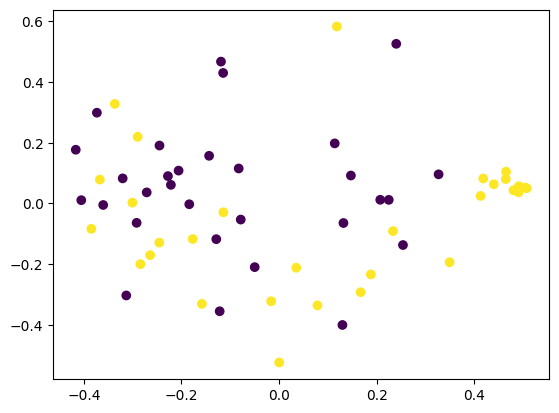

In [13]:
# make a colour map for the points
c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])

plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

## Aumentando a quantidade de shots para melhorar a precisão

In [14]:
n_shots = 10000  # 100 x more shots
raw_data = generate_circuits(circuits, n_shots)

## Visualização

In [15]:
print(raw_data[0])

[array([-1., -1., -1., ...,  1.,  1.,  1.]), array([ 1.,  1.,  1., ..., -1.,  1.,  1.]), array([-1., -1., -1., ...,  1.,  1., -1.]), array([-1.,  1.,  1., ...,  1.,  1., -1.]), array([-1.,  1., -1., ...,  1.,  1.,  1.]), array([ 1., -1., -1., ...,  1.,  1.,  1.]), array([-1.,  1., -1., ..., -1.,  1., -1.]), array([ 1.,  1., -1., ..., -1., -1.,  1.])]


In [16]:
data = process_data(raw_data)

In [17]:
print(data[0])

[-0.0036     -0.0086     -0.003      -0.0134      0.0018      0.0044
  0.0148      0.0122      0.99998704  0.99992604  0.999991    0.99982044
  0.99999676  0.99998064  0.99978096  0.99985116]


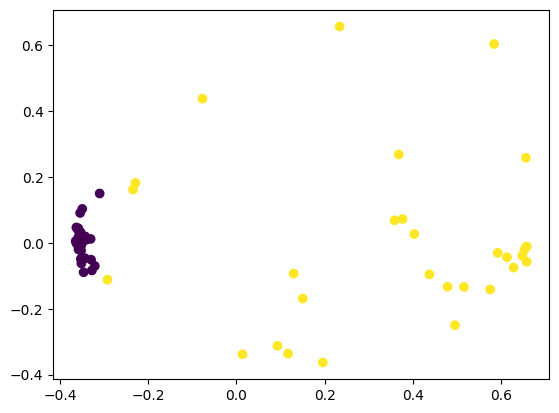

In [18]:
fit = runClass(data)

plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

# Método melhorado com memória quântica

## Início da implementação

In [19]:
n_shots = 50
qubits = 8

## Função para gerar circuitos com memória quântica

In [20]:
def CNOT_sequence(control_wires, target_wires):
    """Apply CNOTs in sequence using the provided control and target wires"""
    for c_wire, t_wire in zip(control_wires, target_wires):
        qml.CNOT([c_wire, t_wire])

def generate_ecircuit(n_shots):

    dev = qml.device("lightning.qubit", wires=qubits * 2, shots=n_shots)
    
    @qml.qnode(dev)
    def enhanced_circuit(ts=False):
        "implement the enhanced circuit, using a random unitary"
    
        if ts == True:
            ops = [qml.RY]
        else:
            ops = [qml.RX, qml.RY, qml.RZ]
    
        weights = np.random.rand(layers, n_shots) * np.pi
        seed = np.random.randint(0, 10000)
    
        for q in range(qubits):
            qml.Hadamard(wires=q)
    
        CNOT_sequence(control_wires=range(qubits), target_wires=range(qubits, 2 * qubits))
        RandomLayers(weights, wires=range(0, qubits), rotations=ops, seed=seed)
        RandomLayers(weights, wires=range(qubits, 2 * qubits), rotations=ops, seed=seed)
        CNOT_sequence(control_wires=range(qubits), target_wires=range(qubits, 2 * qubits))
    
        for q in range(qubits):
            qml.Hadamard(wires=q)
    
        return [qml.sample(op=qml.PauliZ(q)) for q in range(2 * qubits)]
        
    return enhanced_circuit
        

## Gerando circuitos

In [21]:
def generate_ecircuits(circuits, n_shots):
    raw_data = []
    
    for ts in [True, False]:
        for __ in range(circuits):
            enhanced_circuit = generate_ecircuit(n_shots)
            raw_data.append(enhanced_circuit(ts))

    return raw_data

raw_data = generate_ecircuits(circuits, n_shots)

## Visualização

In [22]:
print(raw_data[0])

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1

## Pre-Processamento

In [23]:
data = process_data(raw_data)
print(data[40])

[-0.04    0.08    0.32    0.4    -0.12    0.08    0.12   -0.2    -0.12
  0.      0.24   -0.2    -0.12   -0.04   -0.16   -0.24    0.9984  0.9936
  0.8976  0.84    0.9856  0.9936  0.9856  0.96    0.9856  1.      0.9424
  0.96    0.9856  0.9984  0.9744  0.9424]


## Rodando o classificador

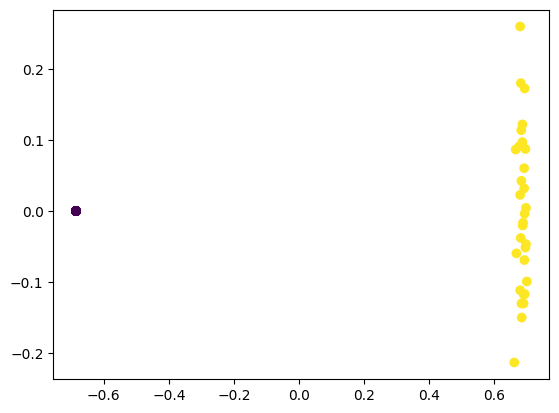

In [24]:
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)

scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

fit = kernel_pca.fit(data).transform(data)

c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])
plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

# Adicionando ruído

In [25]:
def noise_layer(epsilon):
    "apply a random rotation to each qubit"
    for q in range(2 * qubits):
        angles = (2 * np.random.rand(3) - 1) * epsilon
        qml.Rot(angles[0], angles[1], angles[2], wires=q)

@qml.qnode(dev)
def enhanced_circuit(ts=False):
    "implement the enhanced circuit, using a random unitary with a noise layer"

    if ts == True:
        ops = [qml.RY]
    else:
        ops = [qml.RX, qml.RY, qml.RZ]

    weights = np.random.rand(layers, n_shots) * np.pi
    seed = np.random.randint(0, 10000)

    for q in range(qubits):
        qml.Hadamard(wires=q)

    CNOT_sequence(control_wires=range(qubits), target_wires=range(qubits, 2 * qubits))
    RandomLayers(weights, wires=range(0, qubits), rotations=ops, seed=seed)
    RandomLayers(weights, wires=range(qubits, 2 * qubits), rotations=ops, seed=seed)
    noise_layer(np.pi / 4)  # added noise layer
    CNOT_sequence(control_wires=range(qubits, 2 * qubits), target_wires=range(qubits))

    for q in range(qubits):
        qml.Hadamard(wires=qubits + q)

    return [qml.sample(op=qml.PauliZ(q)) for q in range(2 * qubits)]

raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        raw_data.append(enhanced_circuit(ts))

data = process_data(raw_data)

kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
fit = kernel_pca.fit(data).transform(data)

c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])
plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

WireError: Cannot run circuit(s) on lightning.qubit as they contain wires not found on the device: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}